In [34]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import functions.data_wrangling as dw

import os

In [35]:
jra55 = xr.open_dataset('/home/links/ct715/data_storage/reanalysis/jra55_daily/variables/mslp/slp_monthly_jra55_1958_2016.nc')
jra55 = jra55.resample(time='1ME').mean(dim='time')
jra55 = dw.seasonal_mean(jra55, season='djf')
jra55 = jra55.mean('time')
jra55['slp'] = jra55['slp'] / 100  # Convert from Pa to hPa
jra55 = dw.longitude_adjustment(jra55)
jra55

<xarray.Dataset> Size: 44kB
Dimensions:  (lat: 73, lon: 144)
Coordinates:
  * lat      (lat) float64 584B -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float64 1kB -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
Data variables:
    slp      (lat, lon) float32 42kB 1.013e+03 1.013e+03 ... 1.015e+03 1.015e+03

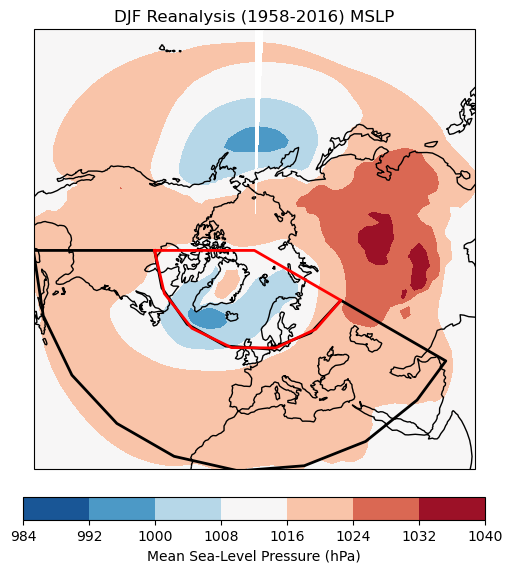

In [36]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Define bounding boxes in degrees
lon_min, lon_max = -90, 60  # 90°W to 60°E
southern_lat_min, southern_lat_max = 20, 55
northern_lat_min, northern_lat_max = 55, 90

def add_box(ax, lon_min, lon_max, lat_min, lat_max, **kwargs):
    """Add a rectangular box to the map."""
    lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
    lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
    ax.plot(lons, lats, transform=ccrs.PlateCarree(), **kwargs)

# Use coordinate variables from any one dataset (assumes all aligned)
lon = jra55['lon']
lat = jra55['lat']

# Plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.NorthPolarStereo()})

mesh = ax.contourf(lon, lat, jra55.slp, transform=ccrs.PlateCarree(), cmap='RdBu_r')

ax.set_title('DJF Reanalysis (1958-2016) MSLP')
ax.coastlines()
ax.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())

# Add boxes
add_box(ax, lon_min, lon_max, southern_lat_min, southern_lat_max, color='black', linewidth=2)
add_box(ax, lon_min, lon_max, northern_lat_min, northern_lat_max, color='red', linewidth=2)

# Colorbar
cbar = fig.colorbar(mesh, ax=ax, orientation='horizontal', shrink=0.6, pad=0.05)
cbar.set_label('Mean Sea-Level Pressure (hPa)')

plt.tight_layout()
plt.show()


## Subtracting global MSLP

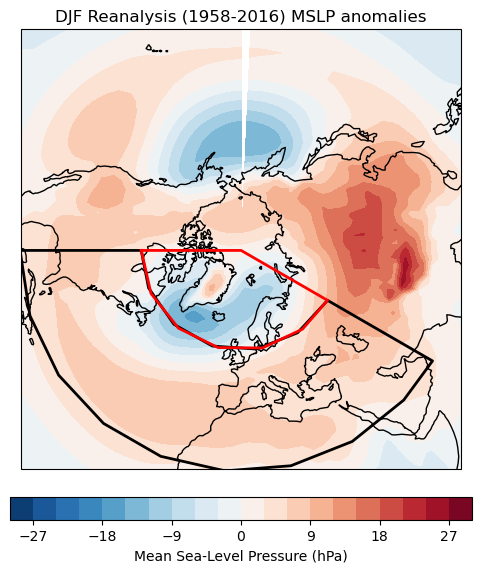

In [37]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Define bounding boxes in degrees
lon_min, lon_max = -90, 60  # 90°W to 60°E
southern_lat_min, southern_lat_max = 20, 55
northern_lat_min, northern_lat_max = 55, 90

def add_box(ax, lon_min, lon_max, lat_min, lat_max, **kwargs):
    """Add a rectangular box to the map."""
    lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
    lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
    ax.plot(lons, lats, transform=ccrs.PlateCarree(), **kwargs)

# Use coordinate variables from any one dataset (assumes all aligned)
lon = jra55['lon']
lat = jra55['lat']

mslp_anom = jra55.slp - 1013.25

# Plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.NorthPolarStereo()})

mesh = ax.contourf(lon, lat, mslp_anom, transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.linspace(-30,30,21))

ax.set_title('DJF Reanalysis (1958-2016) MSLP anomalies')
ax.coastlines()
ax.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())

# Add boxes
add_box(ax, lon_min, lon_max, southern_lat_min, southern_lat_max, color='black', linewidth=2)
add_box(ax, lon_min, lon_max, northern_lat_min, northern_lat_max, color='red', linewidth=2)

# Colorbar
cbar = fig.colorbar(mesh, ax=ax, orientation='horizontal', shrink=0.6, pad=0.05)
cbar.set_label('Mean Sea-Level Pressure (hPa)')

plt.tight_layout()
plt.show()


# Reanalysis alongside PAMIP

In [38]:
main_path = '/home/links/ct715/data_storage/PAMIP/processed_monthly/mslp'
models = sorted(os.listdir(main_path))

mslp = {}
for model in models:
    
    # open datasets and run data checker
    file_path = os.path.join(main_path, model, '*.nc')
    ds = xr.open_mfdataset(file_path, concat_dim='ens_ax', combine='nested')
    
    # take DJF mean
    ds = dw.seasonal_mean(ds, season='djf')
    
    # take ensemble mean
    ds = ds.mean(('ens_ax', 'time'))
    
    # adapt longitude
    ds = dw.longitude_adjustment(ds)
        
    ds['psl'] = ds['psl'] / 100  # convert Pa to hPa
    
    mslp[model] = ds
    
mslp['JRA55'] = jra55.rename({'slp': 'psl'})

In [39]:

mslp['JRA55']

<xarray.Dataset> Size: 44kB
Dimensions:  (lat: 73, lon: 144)
Coordinates:
  * lat      (lat) float64 584B -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float64 1kB -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
Data variables:
    psl      (lat, lon) float32 42kB 1.013e+03 1.013e+03 ... 1.015e+03 1.015e+03

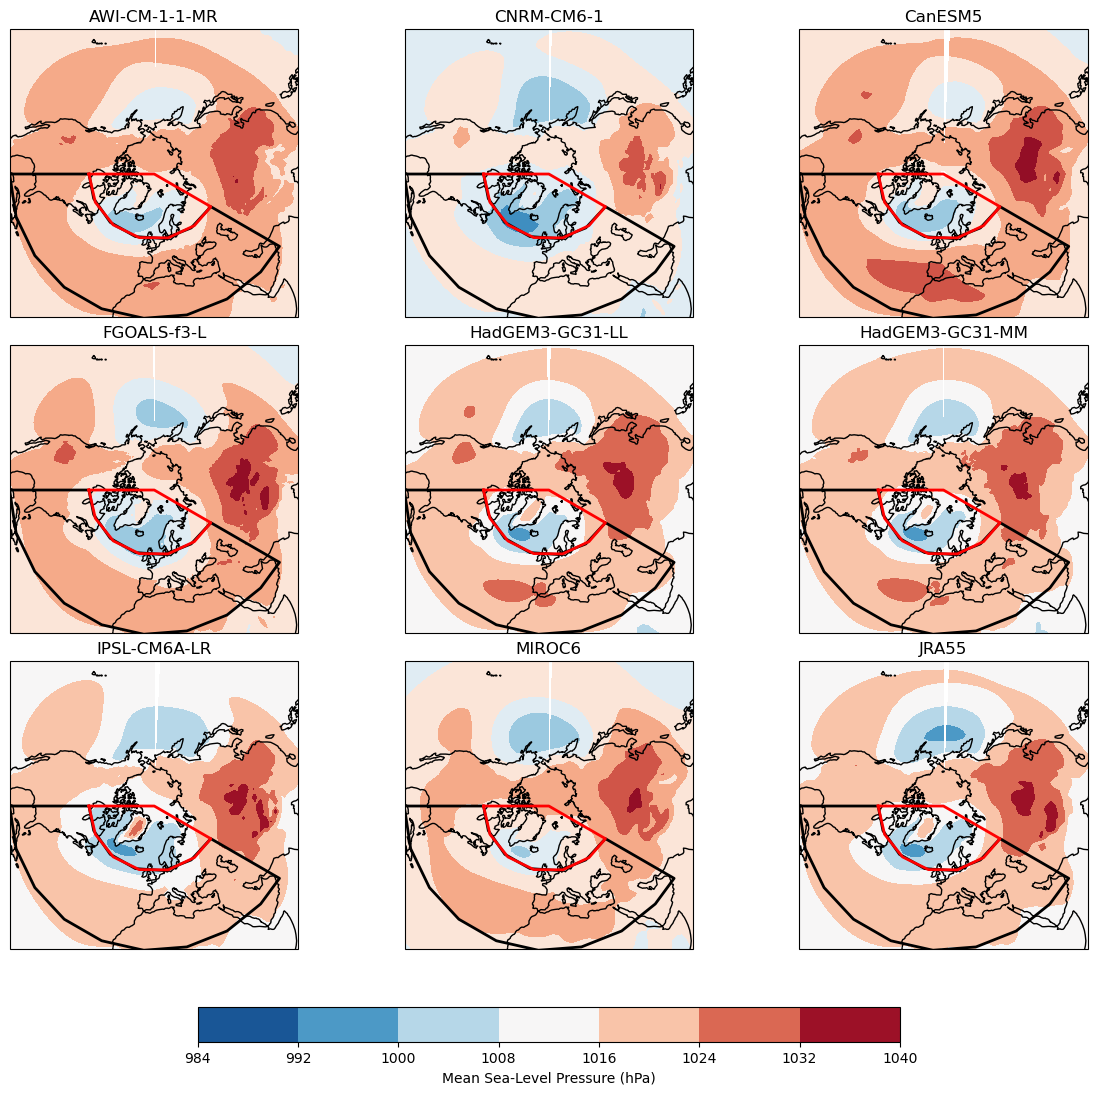

In [40]:
# Define bounding boxes in degrees
lon_min, lon_max = -90, 60  # 90°W to 60°E
southern_lat_min, southern_lat_max = 20, 55
northern_lat_min, northern_lat_max = 55, 90

def add_box(ax, lon_min, lon_max, lat_min, lat_max, **kwargs):
    """Add a rectangular box to the map."""
    lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
    lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
    ax.plot(lons, lats, transform=ccrs.PlateCarree(), **kwargs)

# Plot
n_models = len(mslp)
ncols = 3
nrows = -(-n_models // ncols)  # ceiling division

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows),
                        subplot_kw={"projection": ccrs.NorthPolarStereo()})

axs = axs.flat if n_models > 1 else [axs]

for ax, (model_name, data) in zip(axs, mslp.items()):
    # If there's a time dimension, average over time
    if 'time' in data.dims:
        data = data.mean('time')
        

    
    # Contourf plot
    mesh = ax.contourf(data['lon'].values, data['lat'].values, data.psl.values, transform=ccrs.PlateCarree(), cmap='RdBu_r')
                       #vmin=960, vmax=1040, levels=np.arange(960, 1041, 10))
    ax.set_title(model_name)
    ax.coastlines()
    ax.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())

    # Add boxes
    add_box(ax, lon_min, lon_max, southern_lat_min, southern_lat_max, color='black', linewidth=2)
    add_box(ax, lon_min, lon_max, northern_lat_min, northern_lat_max, color='red', linewidth=2)

# Remove unused axes
for ax in axs[n_models:]:
    fig.delaxes(ax)

plt.tight_layout()
cbar = fig.colorbar(mesh, ax=axs[:n_models], orientation='horizontal', shrink=0.6, pad=0.05)
cbar.set_label('Mean Sea-Level Pressure (hPa)')
plt.show()


## Subtracting global MSLP

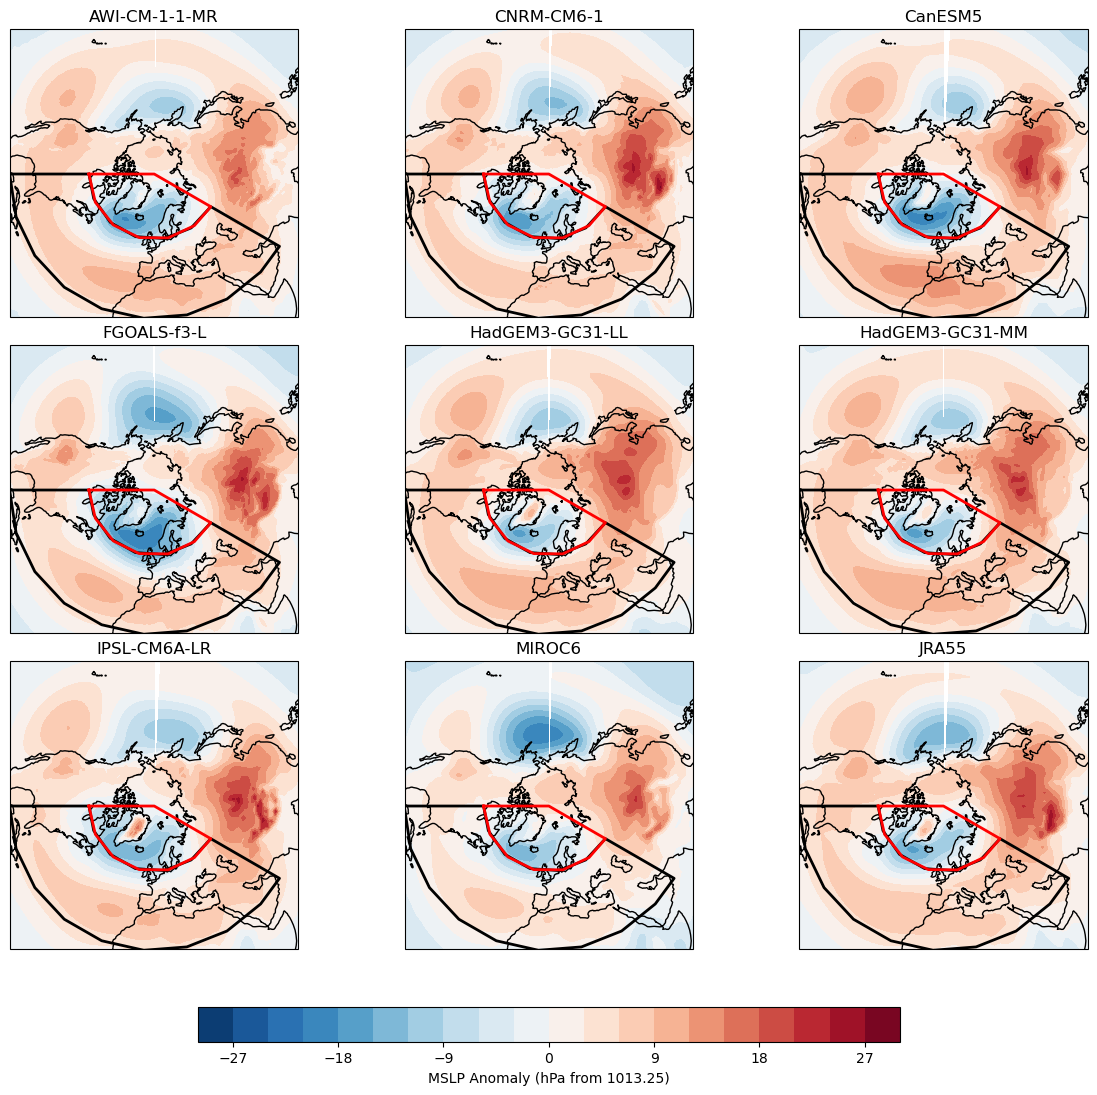

In [41]:
# Define bounding boxes in degrees
lon_min, lon_max = -90, 60  # 90°W to 60°E
southern_lat_min, southern_lat_max = 20, 55
northern_lat_min, northern_lat_max = 55, 90

def add_box(ax, lon_min, lon_max, lat_min, lat_max, **kwargs):
    """Add a rectangular box to the map."""
    lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
    lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
    ax.plot(lons, lats, transform=ccrs.PlateCarree(), **kwargs)

# Plot
n_models = len(mslp)
ncols = 3
nrows = -(-n_models // ncols)  # ceiling division

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows),
                        subplot_kw={"projection": ccrs.NorthPolarStereo()})

axs = axs.flat if n_models > 1 else [axs]

vmax = 30  # adjust if needed
vmin = -vmax

for ax, (model_name, data) in zip(axs, mslp.items()):
    # If there's a time dimension, average over time
    if 'time' in data.dims:
        data = data.mean('time')

    # Subtract standard pressure
    psl_anom = data.psl - 1013.25

    # Contourf plot of anomaly
    mesh = ax.contourf(data['lon'].values, data['lat'].values, psl_anom.values,
                       transform=ccrs.PlateCarree(), cmap='RdBu_r',
                       vmin=vmin, vmax=vmax, levels=np.linspace(vmin, vmax, 21))
    
    ax.set_title(model_name)
    ax.coastlines()
    ax.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())

    # Add boxes
    add_box(ax, lon_min, lon_max, southern_lat_min, southern_lat_max, color='black', linewidth=2)
    add_box(ax, lon_min, lon_max, northern_lat_min, northern_lat_max, color='red', linewidth=2)

# Remove unused axes
for ax in axs[n_models:]:
    fig.delaxes(ax)

plt.tight_layout()
cbar = fig.colorbar(mesh, ax=axs[:n_models], orientation='horizontal', shrink=0.6, pad=0.05)
cbar.set_label('MSLP Anomaly (hPa from 1013.25)')
plt.show()


### Global MSLP calculated for each model and subtracted from corresponding model

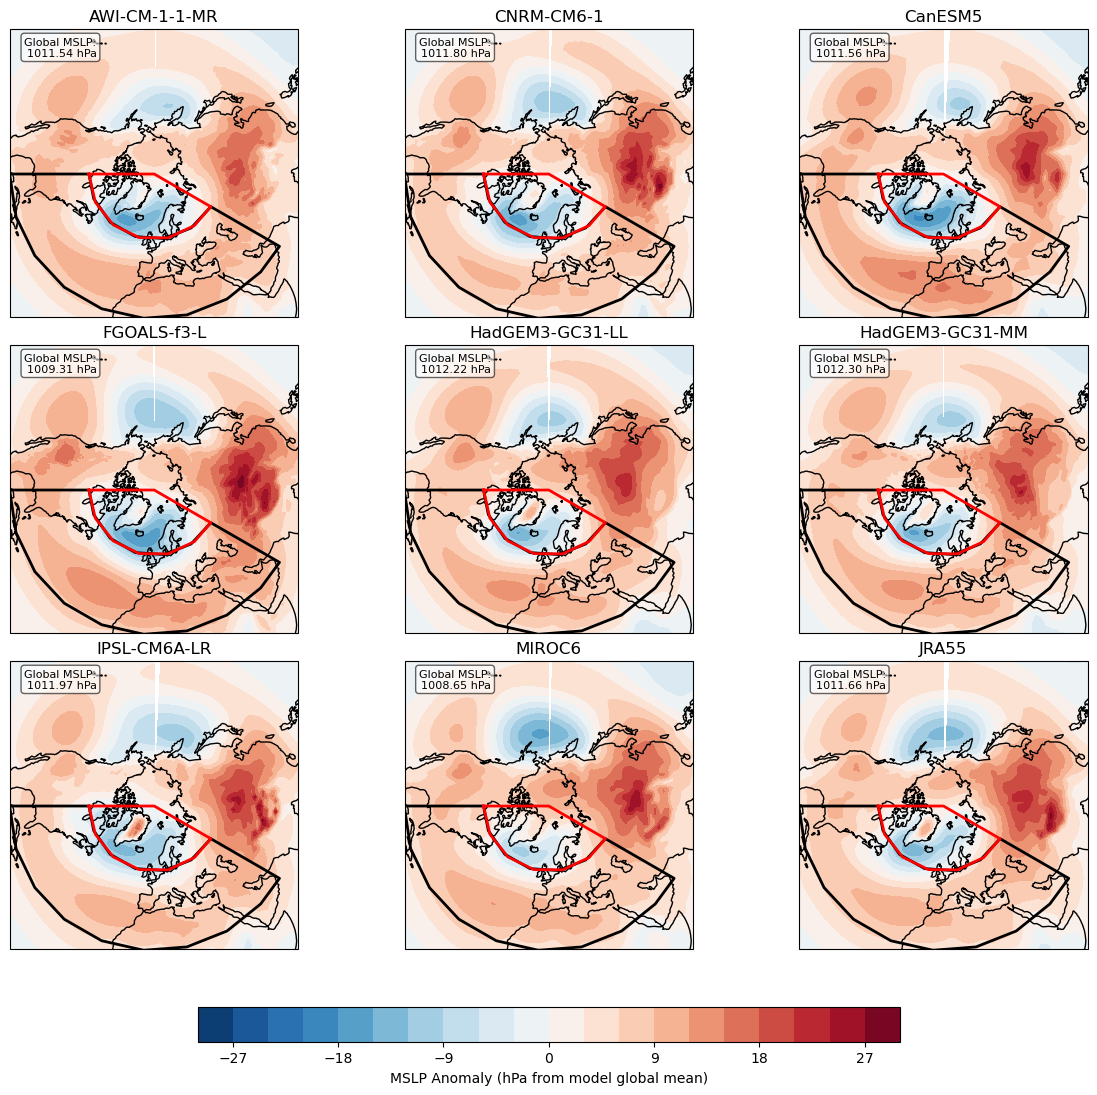


Global mean MSLP values (hPa):
AWI-CM-1-1-MR: 1011.54 hPa
CNRM-CM6-1: 1011.80 hPa
CanESM5: 1011.56 hPa
FGOALS-f3-L: 1009.31 hPa
HadGEM3-GC31-LL: 1012.22 hPa
HadGEM3-GC31-MM: 1012.30 hPa
IPSL-CM6A-LR: 1011.97 hPa
MIROC6: 1008.65 hPa
JRA55: 1011.66 hPa


In [42]:
# Define bounding boxes in degrees
lon_min, lon_max = -90, 60  # 90°W to 60°E
southern_lat_min, southern_lat_max = 20, 55
northern_lat_min, northern_lat_max = 55, 90

def add_box(ax, lon_min, lon_max, lat_min, lat_max, **kwargs):
    """Add a rectangular box to the map."""
    lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
    lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
    ax.plot(lons, lats, transform=ccrs.PlateCarree(), **kwargs)

def area_weighted_mean(psl, lat):
    """Compute area-weighted global mean using cos(lat) weights."""
    weights = np.cos(np.deg2rad(lat))
    weights /= weights.mean()  # normalize weights
    return (psl * weights[:, np.newaxis]).mean()

# Plot
n_models = len(mslp)
ncols = 3
nrows = -(-n_models // ncols)  # ceiling division

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows),
                        subplot_kw={"projection": ccrs.NorthPolarStereo()})

axs = axs.flat if n_models > 1 else [axs]

vmax = 30  # adjust if needed
vmin = -vmax

global_mslp_values = {}

for ax, (model_name, data) in zip(axs, mslp.items()):
    # If there's a time dimension, average over time
    if 'time' in data.dims:
        data = data.mean('time')

    # Calculate global area-weighted mean MSLP
    global_mean = area_weighted_mean(data.psl.values, data['lat'].values)
    global_mslp_values[model_name] = global_mean

    # Subtract global mean
    psl_anom = data.psl - global_mean

    # Plot
    mesh = ax.contourf(data['lon'].values, data['lat'].values, psl_anom.values,
                       transform=ccrs.PlateCarree(), cmap='RdBu_r',
                       vmin=vmin, vmax=vmax, levels=np.linspace(vmin, vmax, 21))
    
    ax.set_title(model_name)
    ax.coastlines()
    ax.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())

    # Add boxes
    add_box(ax, lon_min, lon_max, southern_lat_min, southern_lat_max, color='black', linewidth=2)
    add_box(ax, lon_min, lon_max, northern_lat_min, northern_lat_max, color='red', linewidth=2)
    
    # Add global MSLP text
    ax.text(0.3, 0.9, f"Global MSLP:\n{global_mean:.2f} hPa", transform=ax.transAxes,
            ha='right', va='bottom', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))


# Remove unused axes
for ax in axs[n_models:]:
    fig.delaxes(ax)

plt.tight_layout()
cbar = fig.colorbar(mesh, ax=axs[:n_models], orientation='horizontal', shrink=0.6, pad=0.05)
cbar.set_label('MSLP Anomaly (hPa from model global mean)')
plt.show()

# Print global MSLP values
print("\nGlobal mean MSLP values (hPa):")
for model_name, val in global_mslp_values.items():
    print(f"{model_name}: {val:.2f} hPa")
